In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from lingua import LanguageDetectorBuilder
import matplotlib.pyplot as plt
import geopandas as gpd
import math
import matplotlib.patches as mpatches

In [2]:
listings_url = './data/listings-09-2022.csv'
listings_raw=pd.read_csv(listings_url)

## Convert price to numeric format

In [3]:
listings_raw["price"] = pd.to_numeric(listings_raw["price"].str.replace(r'[$,]', "", regex = True))

## Write neighbourhood_cleansed value into neighbourhood column

In [4]:
listings_raw["neighbourhood"] = listings_raw["neighbourhood_cleansed"]
listings_raw["neighbourhood_group"] = listings_raw["neighbourhood_group_cleansed"]

## Drop listings without reviews

In [5]:
count_of_listings_with_reviews = len(listings_raw[listings_raw["number_of_reviews"] > 0])
count_of_listings_without_reviews = len(listings_raw[listings_raw["number_of_reviews"] == 0])
print("Listings with reviews: ", count_of_listings_with_reviews)
print("Listings without reviews: ", count_of_listings_without_reviews)

Listings with reviews:  13812
Listings without reviews:  2868


In [5]:
listings_with_reviews = listings_raw[listings_raw["number_of_reviews"] > 0]

## Add separate fields for smoke and carbon monoxide detectors

In [8]:
carbon_monoxide_substring = 'Carbon monoxide alarm'
smoke_alarm_substring = 'Smoke alarm'
listings_with_reviews.loc[:, 'has_smoke_alarm'] = listings_with_reviews["amenities"].str.contains(smoke_alarm_substring)
listings_with_reviews.loc[:, 'has_co_alarm'] = listings_with_reviews["amenities"].str.contains(carbon_monoxide_substring)

/tmp/ipykernel_32918/340655119.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_with_reviews.loc[:, 'has_smoke_alarm'] = listings_with_reviews["amenities"].str.contains(smoke_alarm_substring)
/tmp/ipykernel_32918/340655119.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_with_reviews.loc[:, 'has_co_alarm'] = listings_with_reviews["amenities"].str.contains(carbon_monoxide_substring)


## Drop listings without beds

In [9]:
count_of_listings_without_beds = len(listings_with_reviews[listings_with_reviews["beds"].isnull()])
count_of_listings_with_beds = len(listings_with_reviews[listings_with_reviews["beds"].notnull()])
print("Listings without information about beds: ", count_of_listings_without_beds)
print("Listings with information about beds: ", count_of_listings_with_beds)

Listings without information about beds:  234
Listings with information about beds:  13578


In [10]:
listings_with_beds = listings_with_reviews[listings_with_reviews["beds"].notnull()]

## Drop listings without bedrooms

In [11]:
count_of_listings_without_bedrooms = len(listings_with_reviews[listings_with_reviews["bedrooms"].isnull()])
count_of_listings_with_bedrooms = len(listings_with_reviews[listings_with_reviews["bedrooms"].notnull()])
print("Listings without information about bedrooms: ", count_of_listings_without_bedrooms)
print("Listings with information about bedrooms: ", count_of_listings_with_bedrooms)

Listings without information about bedrooms:  1109
Listings with information about bedrooms:  12703


In [12]:
listings_with_bedrooms = listings_with_reviews[listings_with_reviews["bedrooms"].notnull()]

In [13]:
def get_fitted_X(X, polynomial_degree: int):
    poly_reg=PolynomialFeatures(degree=polynomial_degree)
    X_poly=poly_reg.fit_transform(X)
    return X_poly

def get_linear_regression_model(X, y, polynomial_degree: int):
    X_poly_fitted=get_fitted_X(X, polynomial_degree)
    lin_reg_model=LinearRegression()
    lin_reg_model.fit(X_poly_fitted,y)
    return lin_reg_model

def get_mse(X_train, y_train, X_test, y_test, polynomial_degree: int):
    lin_reg_model = get_linear_regression_model(X_train, y_train, polynomial_degree)
    X_test_poly_fitted=get_fitted_X(X_test, polynomial_degree)
    y_predicted = lin_reg_model.predict(X_test_poly_fitted)
    return mean_squared_error(y_test, y_predicted)

def get_r2_score(X_train, y_train, X_test, y_test, polynomial_degree: int):
    lin_reg_model = get_linear_regression_model(X_train, y_train, polynomial_degree)
    X_test_poly_fitted=get_fitted_X(X_test, polynomial_degree)
    y_predicted = lin_reg_model.predict(X_test_poly_fitted)
    return r2_score(y_test, y_predicted)

def print_mse_and_r2_plots(range: range, mse_list: list, r2_list: list, title = ''):
    fig, ax = plt.subplots(2, sharex=True)
    if title != '':
        fig.suptitle(title)
    ax[0].plot(range, mse_list, color='blue')
    ax[0].set_xlabel('Polynomial regression degree')
    ax[0].set_ylabel('mean squared error')
    ax[0].set_yscale('log')
    ax[1].plot(range, r2_list, color='red')
    ax[1].set_xlabel('Polynomial regression degree')
    ax[1].set_ylabel('R² score')
    ax[1].set_yscale('log')

In [14]:
relevant_columns = [
  "neighbourhood", 
  "property_type", 
  "room_type", 
  "accommodates", 
  "has_smoke_alarm", 
  "has_co_alarm",
  "beds"
]

X_beds=listings_with_beds[relevant_columns].values
y_beds=listings_with_beds["price"].values

In [15]:
X_beds_train,X_beds_test,y_beds_train,y_beds_test=train_test_split(X_beds,y_beds,test_size=0.2,random_state=0)

In [16]:
mse_list = []
r2_list = []

degree_range = range(1, 11)

X = X_beds
y = y_beds

for polynomial_degree in degree_range:
    mse = get_mse(X_train=X, X_test=X, y_train=y, y_test=y, polynomial_degree=polynomial_degree)
    mse_list.append(mse)
    r2 = get_r2_score(X_train=X, X_test=X, y_train=y, y_test=y, polynomial_degree=polynomial_degree)
    r2_list.append(r2)

print_mse_and_r2_plots(range=degree_range, mse_list=mse_list, r2_list=r2_list)

ValueError: could not convert string to float: 'Zehlendorf  Südwest'

# Playing around with NLP and the reviews

In [6]:
reviews_url = './data/reviews-09-2022.csv'
reviews_raw = pd.read_csv(reviews_url)

In [7]:
reviews_filtered = reviews_raw[reviews_raw["comments"].notna()]

In [ ]:
# detector = LanguageDetectorBuilder.from_all_languages().with_preloaded_language_models().build()

# reviews_language = reviews_filtered.copy()
# for i, row in reviews_language.iterrows():
#     if i % 100 == 0:
#       print("Now processing iteration ", i)
#     confidence_values = detector.compute_language_confidence_values(row["comments"])
#     language_lowercase = str(confidence_values[0].language).split(".")[1].lower()
#     reviews_language.at[i,'language_detected'] = language_lowercase
#     reviews_language.at[i,'language_confidence'] = confidence_values[0].value

# reviews_language_url = './data/reviews-09-2022-language.csv'
# reviews_language.to_csv(reviews_language_url, index=False, sep=";", lineterminator="\r")

'\ndetector = LanguageDetectorBuilder.from_all_languages().with_preloaded_language_models().build()\n\nreviews_language = reviews_filtered.copy()\nfor i, row in reviews_language.iterrows():\n    if i % 100 == 0:\n      print("Now processing iteration ", i)\n    confidence_values = detector.compute_language_confidence_values(row["comments"])\n    language_lowercase = str(confidence_values[0].language).split(".")[1].lower()\n    reviews_language.at[i,\'language_detected\'] = language_lowercase\n    reviews_language.at[i,\'language_confidence\'] = confidence_values[0].value\n\nreviews_language_url = \'./data/reviews-09-2022-language.csv\'\nreviews_language.to_csv(reviews_language_url, index=False, sep=";", lineterminator="\r")\n'

The custom line terminator `\r` is necessary because some of the comments have linebreaks (`\n`) which break the interpretation of the csv file.

In [2]:
reviews_language_url = './data/reviews-09-2022-language.csv'
reviews_language_read = pd.read_csv(reviews_language_url, sep=";", lineterminator="\r")

In [3]:
min_required_confidence = 0.6
reviews_confident_language = reviews_language_read[reviews_language_read["language_confidence"] > min_required_confidence]
review_language_occurencies = reviews_confident_language.groupby(by="language_detected").size()
top_10_review_languages = review_language_occurencies.sort_values(ascending=False).head(10)
top_10_review_languages

language_detected
english    251904
german     116793
french      17428
spanish     11216
dutch        4991
italian      4316
russian      2862
chinese      1643
korean       1577
danish       1474
dtype: int64

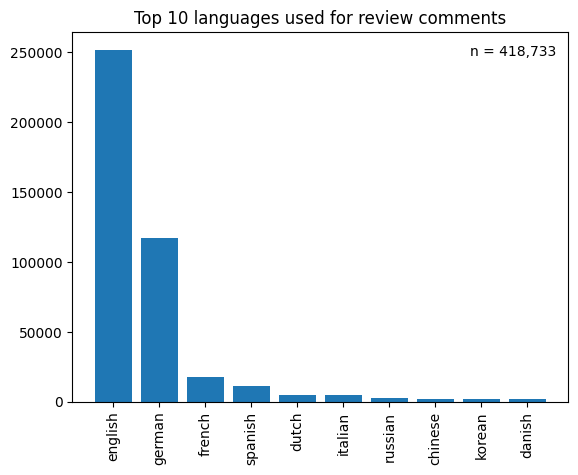

In [12]:
labels = top_10_review_languages.keys()
sizes = top_10_review_languages.values

fig, ax = plt.subplots()
ax.bar(labels, sizes)
plt.xticks(rotation=90)
ax.set_title("Top 10 languages used for review comments")

legend_patch = mpatches.Patch(color='white', label='n = ' + f'{len(reviews_confident_language):,}')
ax.legend(handles=[legend_patch], frameon = False)

plt.show()

In [10]:
berlin_neighbourhoods_url = "./data/neighbourhoods-09-2022.geojson"
berlin_neighbourhoods_raw = gpd.read_file(berlin_neighbourhoods_url)
berlin_neighbourhoods_raw[berlin_neighbourhoods_raw["neighbourhood"].isnull()]

,neighbourhood,neighbourhood_group,geometry
11,None,None,"MULTIPOLYGON (((13.61659 52.58154, 13.61458 52..."
12,None,None,"MULTIPOLYGON (((13.61668 52.57868, 13.60703 52..."


<AxesSubplot: >

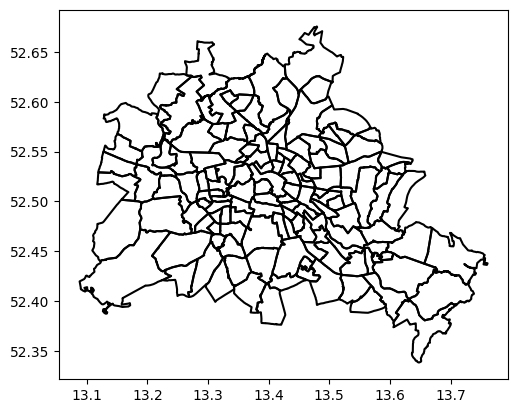

In [14]:
berlin_neighbourhoods = berlin_neighbourhoods_raw[berlin_neighbourhoods_raw["neighbourhood"].notnull()]
berlin_neighbourhoods.boundary.plot(color="black")

In [15]:
def get_neighbourhoods_and_review_shares_for_language(language, reviews=pd.DataFrame([])):
  listings_and_neighbourhoods = berlin_neighbourhoods.merge(listings_with_reviews, on="neighbourhood", how="right")
  listings_and_neighbourhoods = listings_and_neighbourhoods.rename(columns={"id": "listing_id"})

  if reviews.empty:
    reviews = reviews_confident_language

  language_reviews = reviews[reviews["language_detected"] == language]
  language_listings_and_neighbourhoods = language_reviews.merge(listings_and_neighbourhoods, on="listing_id")
  language_review_counts = language_listings_and_neighbourhoods.groupby(by="neighbourhood").size().reset_index(name='counts')
  
  berlin_neighbourhoods_with_counts = berlin_neighbourhoods.merge(language_review_counts, how="left").fillna(0)

  total_occurencies = reviews.groupby(by="language_detected").size()[language]
  berlin_neighbourhoods_with_counts["share"] = berlin_neighbourhoods_with_counts["counts"] / total_occurencies

  return (berlin_neighbourhoods_with_counts, total_occurencies)

def plot_review_share_per_neighbourhood_for_multiple_language(languages: list[str]):
  rows_count = math.ceil(len(languages) / 2)
  fig, axs = plt.subplots(nrows=rows_count, ncols=2, figsize=(15, 15))

  ravelled_axes = axs.ravel()

  if len(ravelled_axes) > len(languages):
    fig.delaxes(ravelled_axes[-1])

  for (index, language), ax in zip(enumerate(languages), ravelled_axes):
    (language_data, total_occurencies) = get_neighbourhoods_and_review_shares_for_language(language)

    plot = language_data.plot(column = "share", ax = ax, legend=True, legend_kwds={'label': "Share of all reviews in " + language})
    ax.plot = plot
    ax.set_title(language)

    legend_patch = mpatches.Patch(color='white', label='n = ' + f'{total_occurencies:,}')
    ax.legend(handles=[legend_patch], frameon = False)
  
  fig.suptitle("Share of reviews in the respective language per neighbourhood", fontsize=16)
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()


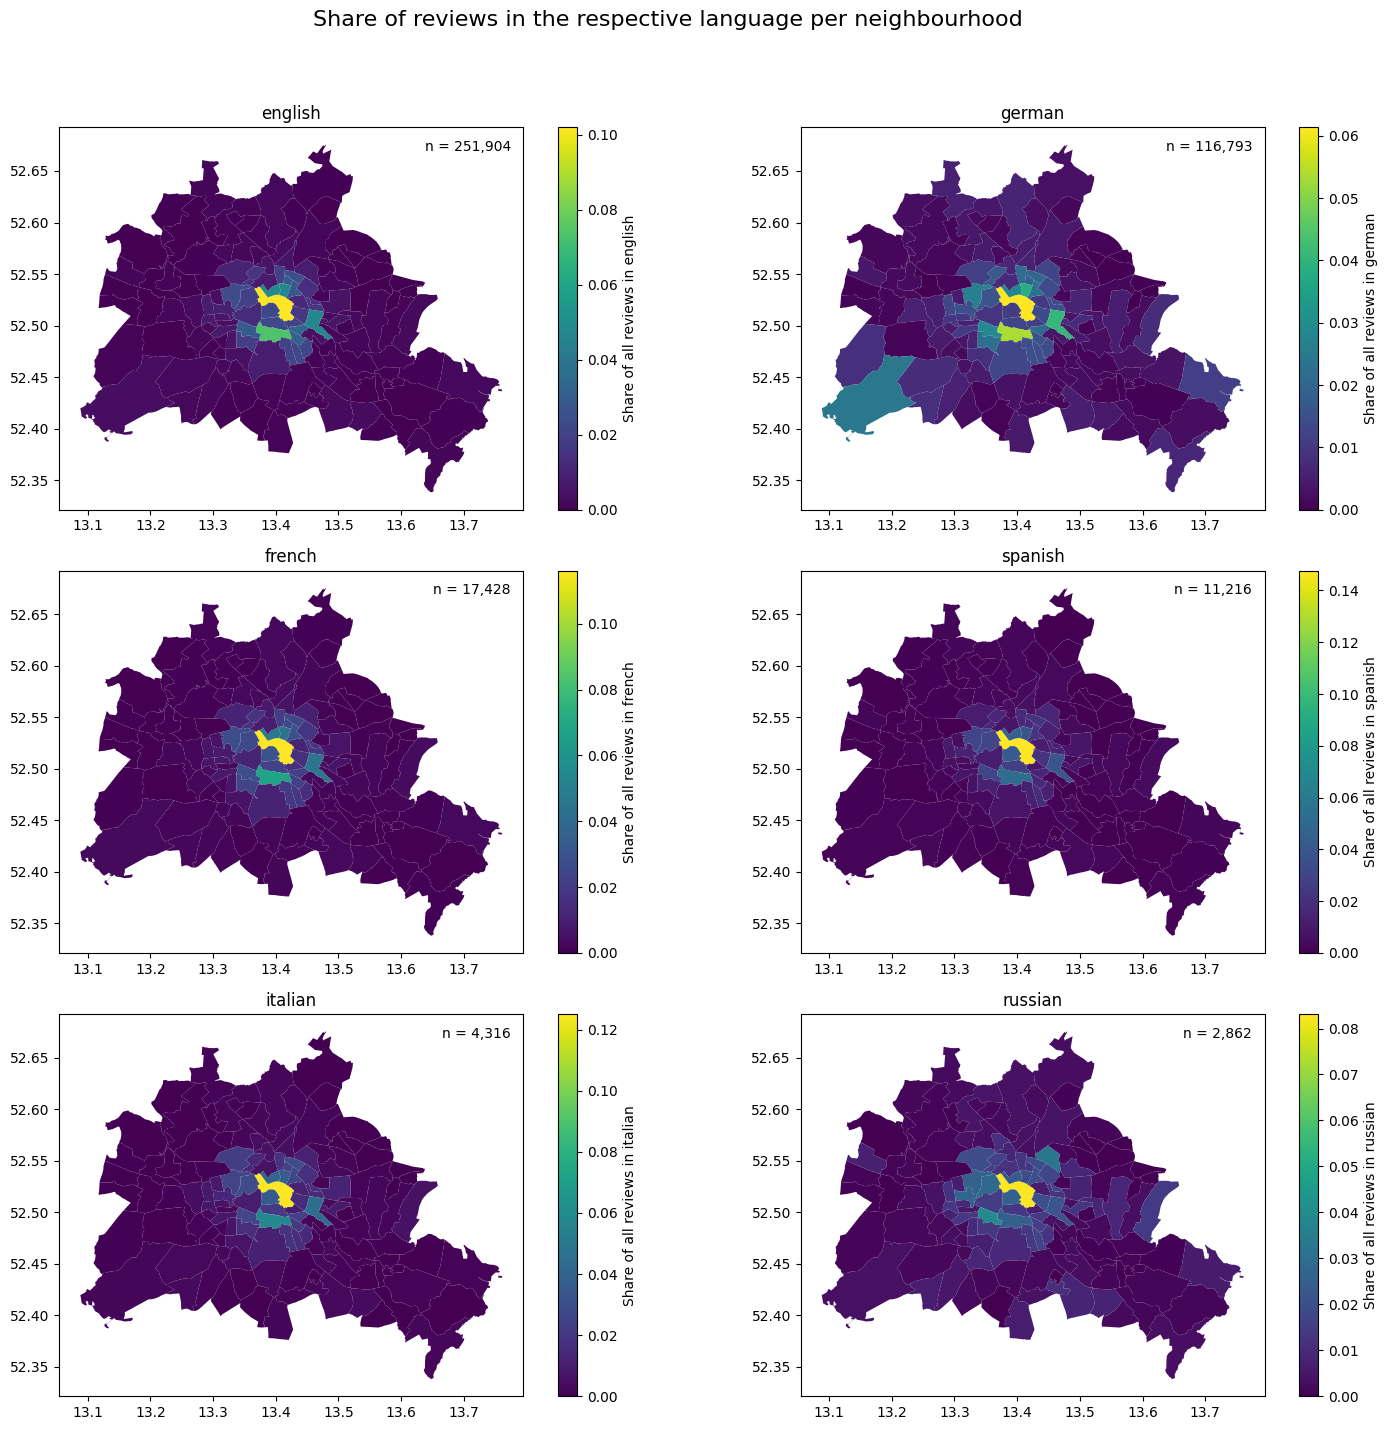

In [16]:
languages = ["english", "german", "french", "spanish", "italian", "russian"]
plot_review_share_per_neighbourhood_for_multiple_language(languages)

In [17]:
detector = LanguageDetectorBuilder.from_all_languages().with_preloaded_language_models().build()

In [18]:
listings_with_name = listings_with_reviews.head(100)[listings_with_reviews["name"].notna()].copy()
for i, row in listings_with_name.iterrows():
  confidence_values = detector.compute_language_confidence_values(row["name"])

  description_language_lowercase = str(confidence_values[0].language).split(".")[1].lower()
  listings_with_name.at[i,'name_language'] = description_language_lowercase
  listings_with_name.at[i,'name_language_confidence'] = confidence_values[0].value

listings_with_name["name_language_confidence"].describe()

/tmp/ipykernel_51663/368137675.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listings_with_name = listings_with_reviews.head(100)[listings_with_reviews["name"].notna()].copy()


count    100.000000
mean       0.366477
std        0.196001
min        0.068038
25%        0.218787
50%        0.328708
75%        0.482415
max        0.888881
Name: name_language_confidence, dtype: float64

In [19]:
listings_with_name_and_description = listings_with_reviews[listings_with_reviews["name"].notna() & listings_with_reviews["description"].notna()]
listings_with_name_and_description.reset_index(inplace=True)

In [32]:
# listings_languages = listings_with_name_and_description.copy()

# for i, row in listings_languages.iterrows():
#   if i % 100 == 0:
#     print("Now processing iteration ", i)
#   confidence_values_description = detector.compute_language_confidence_values(row["description"])

#   description_language_lowercase = str(confidence_values_description[0].language).split(".")[1].lower()
#   listings_languages.at[i,'description_language'] = description_language_lowercase
#   listings_languages.at[i,'description_language_confidence'] = confidence_values_description[0].value

# listings_language_url = './data/listings-09-2022-language.csv'

# listings_languages.drop(columns=["index"]).to_csv(listings_language_url, index=False, sep=";", lineterminator="\r")

In [11]:
listings_language_url = './data/listings-09-2022-language.csv'
listings_language_read = pd.read_csv(listings_language_url, sep=";", lineterminator="\r")

In [21]:
listings_language_read["description_language_confidence"].describe()

count    13612.000000
mean         0.988646
std          0.082567
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: description_language_confidence, dtype: float64

In [22]:
min_required_confidence = 0.6
listings_desc_confident_language = listings_language_read[listings_language_read["description_language_confidence"] > min_required_confidence]
listing_desc_language_occurencies = listings_desc_confident_language.groupby(by="description_language").size()
top_10_listing_languages = listing_desc_language_occurencies.sort_values(ascending=False).head(10)
top_10_listing_languages

description_language
english       8637
german        4676
russian         52
spanish         22
french          21
italian         12
dutch            5
polish           5
turkish          4
portuguese       4
dtype: int64

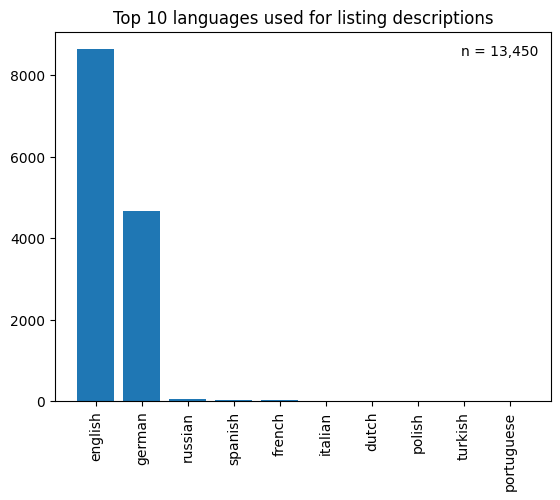

In [23]:
labels = top_10_listing_languages.keys()
sizes = top_10_listing_languages.values

fig, ax = plt.subplots()
ax.bar(labels, sizes)
plt.xticks(rotation=90)
ax.set_title("Top 10 languages used for listing descriptions")

legend_patch = mpatches.Patch(color='white', label='n = ' + f'{len(listings_desc_confident_language):,}')
ax.legend(handles=[legend_patch], frameon = False)

plt.show()

In [24]:
# import matplotlib.colors as colors
#  vmin, vmax, vcenter = 0, language_data.counts.max(), language_data.counts.max() / 2
# divnorm = colors.TwoSlopeNorm(vmin=vmin, vmax=vmax, vcenter=vcenter)
# cbar = plt.cm.ScalarMappable(norm=divnorm)
# # Divide existing axes and create
# # new axes at right side of image
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.15)
# fig.colorbar(cbar, cax=cax, label="Number of reviews")

def get_neighbourhoods_and_description_counts_for_language(language):
  language_listings = listings_desc_confident_language[listings_desc_confident_language["description_language"] == language]
  language_counts = language_listings.groupby(by="neighbourhood").size().reset_index(name='counts')
  
  return berlin_neighbourhoods.merge(language_counts, how="left").fillna(0)

def plot_description_shares_per_neighbourhood_for_multiple_languages(languages: list[str]):
  rows_count = math.ceil(len(languages) / 2)
  fig, axs = plt.subplots(nrows=rows_count, ncols=2, figsize=(15, 15))

  ravelled_axes = axs.ravel()

  if len(ravelled_axes) > len(languages):
    fig.delaxes(ravelled_axes[-1])

  for (index, language), ax in zip(enumerate(languages), ravelled_axes):
    language_data = get_neighbourhoods_and_description_counts_for_language(language)
    total_occurencies = listing_desc_language_occurencies[language]
    language_data["share"] = language_data["counts"] / total_occurencies
    
    ax.plot = language_data.plot(column = "share", ax = ax, legend=True, legend_kwds={'label': "Share of all descriptions in " + language})
    ax.set_title(language)

    legend_patch = mpatches.Patch(color='white', label='n = ' + f'{total_occurencies:,}')
    ax.legend(handles=[legend_patch], frameon = False)
  
  fig.suptitle("Share of descriptions in the respective language per neighbourhood", fontsize=22)
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

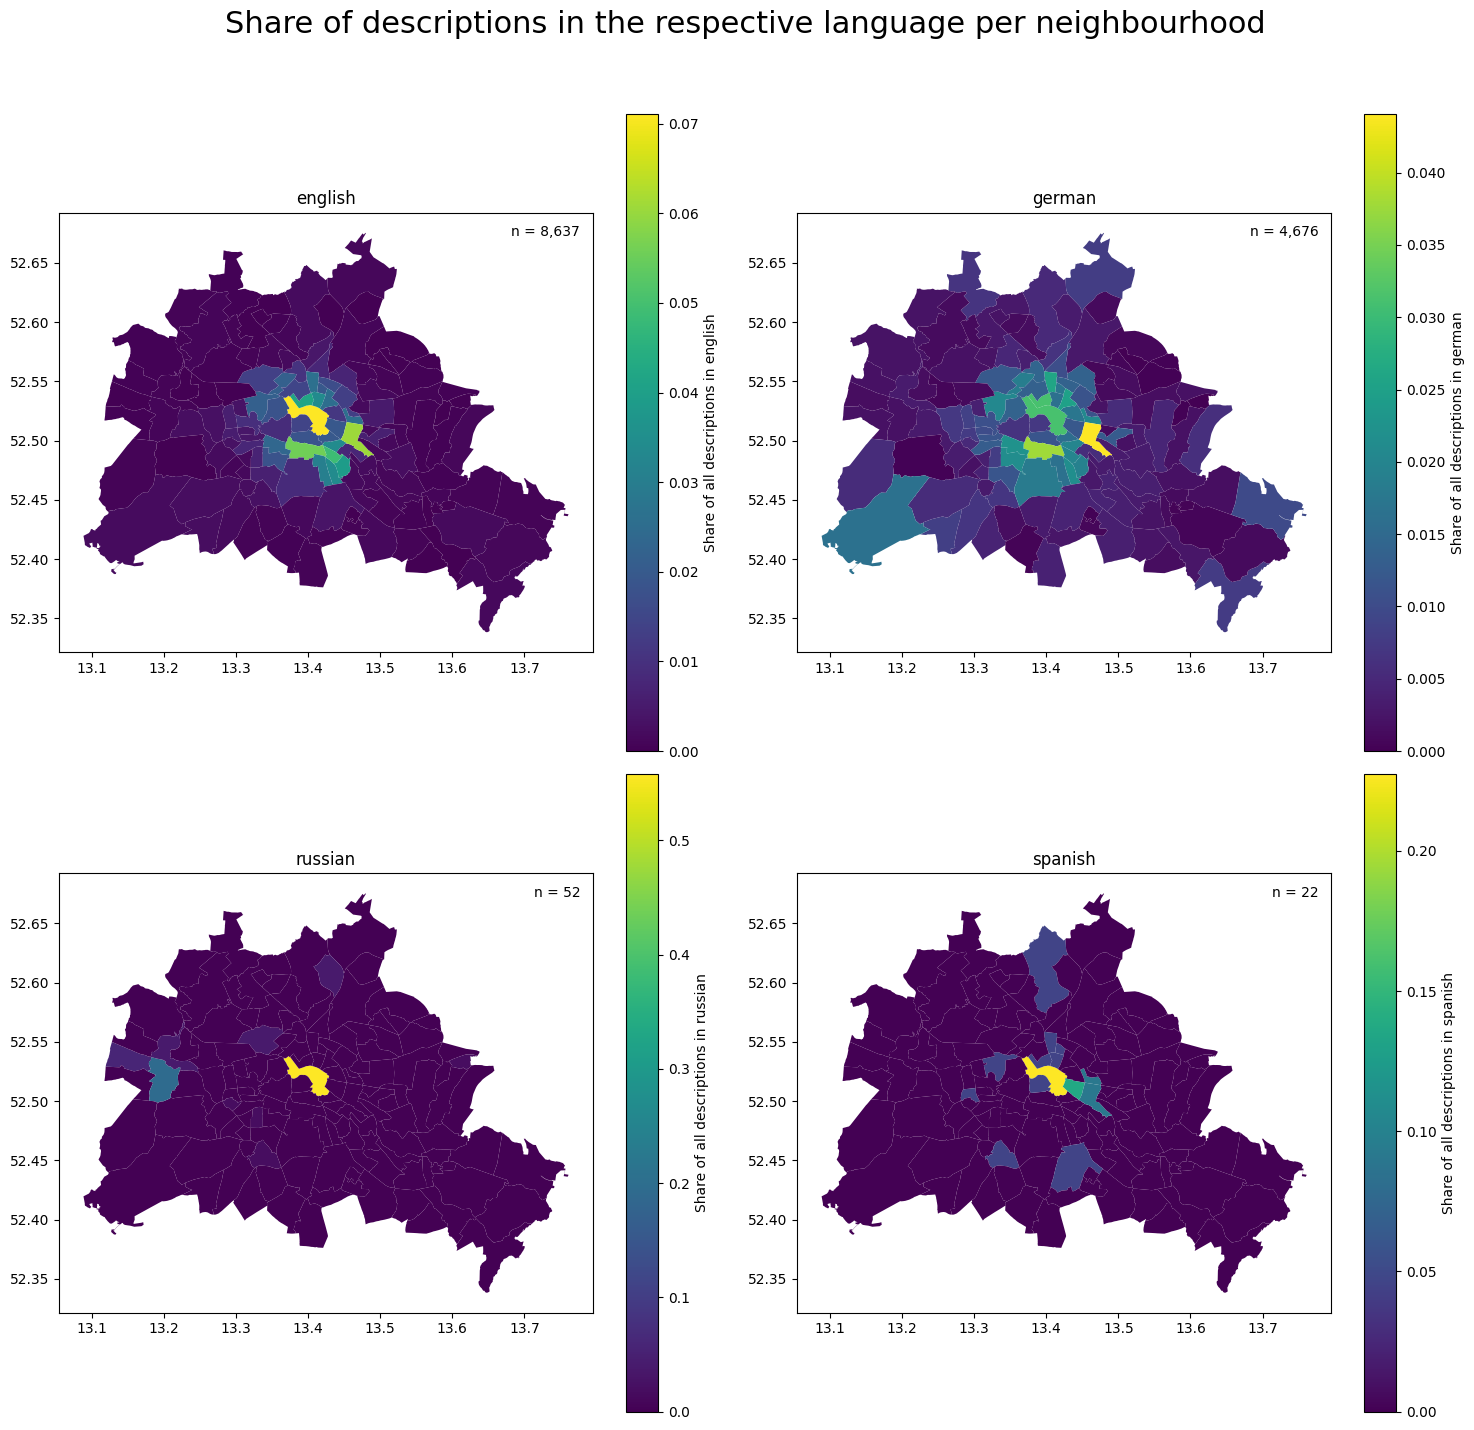

In [25]:
plot_description_shares_per_neighbourhood_for_multiple_languages(["english", "german", "russian", "spanish" ])

In [26]:
get_neighbourhoods_and_description_counts_for_language("russian").sort_values(by="counts", ascending=False).head(5)[["neighbourhood", "counts"]]

,neighbourhood,counts
15,Alexanderplatz,29.0
50,Wilhelmstadt,10.0
45,Brunsbütteler Damm,3.0
19,Parkviertel,2.0
113,Spandau Mitte,2.0


In [27]:
russian_listings = listings_desc_confident_language[listings_desc_confident_language["description_language"] == "russian"]
russian_listings_in_wilhelmstadt = russian_listings[russian_listings["neighbourhood"] == "Wilhelmstadt"]
russian_listings_in_wilhelmstadt.sort_values("host_id")[["host_id", "price", "accommodates", "name"]]

,host_id,price,accommodates,name
2818,52747435,60.0,4,Двухкомнатная квартира на Штаакенер (19)
6147,52747435,56.0,4,Двухкомнатная квартира на Штаакенер (32)
6359,52747435,60.0,5,Cosy 2rooms Apartment in Spandau area (2)
6838,52747435,60.0,4,Двухкомнатная квартира на Штаакенер (5)
7199,52747435,57.0,4,Двухкомнатная квартира на Штаакенер (24.2)
4623,79430806,55.0,5,Stylish 2-rooms flat on Staakenerstr. Spandau(21)
5860,79430806,55.0,5,Comfy 2rooms flat in Spandau (29)
6474,79430806,51.0,4,2Rooms flat in quiet neighborhood/Spandau (22)
7162,79430806,53.0,4,Small 2Rooms flat (24.1)/Spandau
7419,79430806,55.0,5,Nice 2Rooms flat/Spandau (17)


## Sentiment analysis

In [15]:
english_reviews = reviews_confident_language[reviews_confident_language["language_detected"] == "english"]

In [12]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

from flair.models import TextClassifier
from flair.data import Sentence
from segtok.segmenter import split_single

/home/lebkuchen/.local/share/virtualenvs/programming-for-data-science-project-3cOvEbYV/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-01-11 14:12:30.904272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-11 14:12:34.129161: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-11 14:12:34.129471: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.

In [30]:
classifier = TextClassifier.load('en-sentiment')

2023-01-11 11:36:37,712 loading file /home/lebkuchen/.flair/models/sentiment-en-mix-distillbert_4.pt


In [31]:
def get_sentences_from_text(text: str):
    sentences = [sent for sent in split_single(text)]
    return sentences

def predict(sentence: str):
    if sentence == "":
        return 0
    text = Sentence(sentence)
    classifier.predict(text)
    value = text.labels[0].to_dict()['value'] 
    if value == 'POSITIVE':
        result = text.to_dict()['all labels'][0]['confidence']
    else:
        result = -(text.to_dict()['all labels'][0]['confidence'])
    return round(result, 3)

def get_scores(sentences):
    results = []
    
    for i in range(0, len(sentences)): 
        results.append(predict(sentences[i]))
    return results

def get_sum(scores):
    result = round(sum(scores), 3)
    return result

In [94]:
english_reviews_sample = english_reviews.sample(n = 50000)

In [97]:
# reviews_with_sentiment = english_reviews_sample.copy()
# reviews_with_sentiment.reset_index(inplace=True)

# for index, review in reviews_with_sentiment.iterrows():
#   if index % 100 == 0:
#     print("Now processing iteration ", index)
  
#   review_comment = review["comments"]
#   comment_lowercase = review_comment.lower()
#   comment_without_html_linebreaks = comment_lowercase.replace("<br/>", "")

#   sentences = get_sentences_from_text(comment_without_html_linebreaks)
#   scores = get_scores(sentences)
#   sentiment_sum = get_sum(scores)
  
#   reviews_with_sentiment.at[index, 'sentiment'] = sentiment_sum

# reviews_sentiment_url = './data/reviews-09-2022-sentiment.csv'
# reviews_with_sentiment.drop(columns=["index"]).to_csv(reviews_sentiment_url, index=False, sep=";", lineterminator="\r")

Now processing iteration  0
Now processing iteration  100
Now processing iteration  200
Now processing iteration  300
Now processing iteration  400
Now processing iteration  500
Now processing iteration  600
Now processing iteration  700
Now processing iteration  800
Now processing iteration  900
Now processing iteration  1000
Now processing iteration  1100
Now processing iteration  1200
Now processing iteration  1300
Now processing iteration  1400
Now processing iteration  1500
Now processing iteration  1600
Now processing iteration  1700
Now processing iteration  1800
Now processing iteration  1900
Now processing iteration  2000
Now processing iteration  2100
Now processing iteration  2200
Now processing iteration  2300
Now processing iteration  2400
Now processing iteration  2500
Now processing iteration  2600
Now processing iteration  2700
Now processing iteration  2800
Now processing iteration  2900
Now processing iteration  3000
Now processing iteration  3100
Now processing itera

In [4]:
reviews_sentiment_url = './data/reviews-09-2022-sentiment.csv'
reviews_sentiment_read = pd.read_csv(reviews_sentiment_url, sep=";", lineterminator="\r")

In [35]:
for index, review in reviews_sentiment_read.iterrows():
  sentiment_category = "positive" if review["sentiment"] > 0 else "negative"
  reviews_sentiment_read.at[index, 'sentiment_category'] = sentiment_category

positive_negative_occurencies = reviews_sentiment_read.groupby(by="sentiment_category").size()

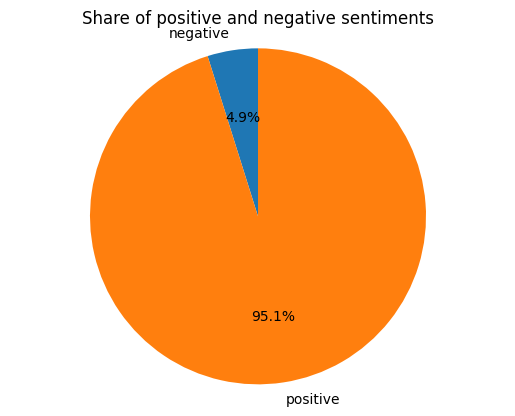

In [41]:
labels = positive_negative_occurencies.keys()
sizes = positive_negative_occurencies.values

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax.axis('equal')
ax.set_title("Share of positive and negative sentiments")

plt.show()

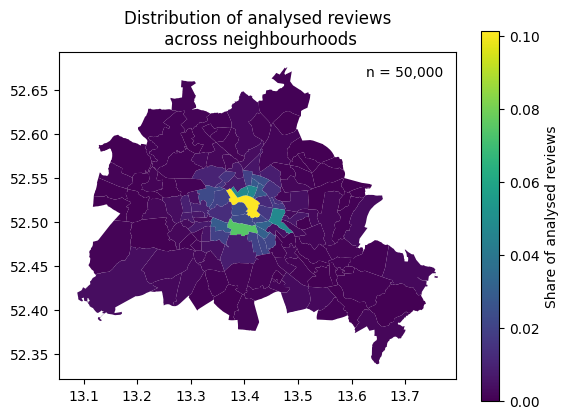

In [42]:
(review_sentiment_shares, analysed_occurencies) = get_neighbourhoods_and_review_shares_for_language(language="english", reviews=reviews_sentiment_read)
fig, ax = plt.subplots()
ax.plot = (review_sentiment_shares).plot(column = "share", ax = ax, legend=True, legend_kwds={'label': "Share of analysed reviews"})

legend_patch = mpatches.Patch(color='white', label='n = ' + f'{analysed_occurencies:,}')
ax.legend(handles=[legend_patch], frameon = False)
ax.set_title("Distribution of analysed reviews\n across neighbourhoods")

plt.show()


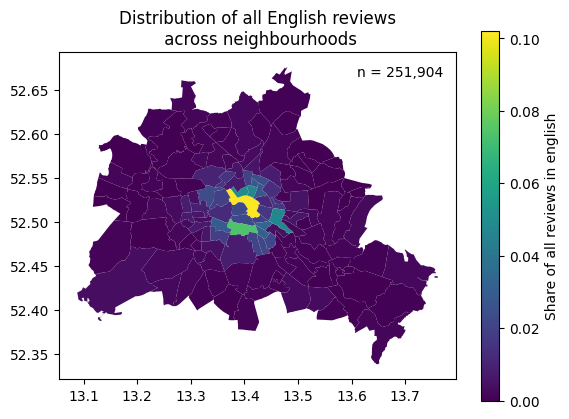

In [43]:
language = "english"
(reviews_english_total_shares, total_occurencies) = get_neighbourhoods_and_review_shares_for_language(language)

fig, ax = plt.subplots()
plot = reviews_english_total_shares.plot(column = "share", ax = ax, legend=True, legend_kwds={'label': "Share of all reviews in " + language})
ax.plot = plot

legend_patch = mpatches.Patch(color='white', label='n = ' + f'{total_occurencies:,}')
ax.legend(handles=[legend_patch], frameon = False)
ax.set_title("Distribution of all English reviews\n across neighbourhoods")

plt.show()

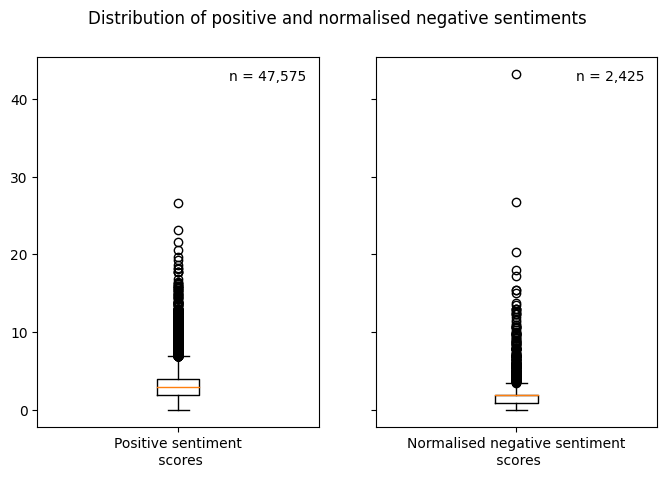

In [44]:
positive_reviews = reviews_sentiment_read[reviews_sentiment_read["sentiment_category"] == "positive"]["sentiment"]
negative_reviews = reviews_sentiment_read[reviews_sentiment_read["sentiment_category"] == "negative"]["sentiment"]
negative_reviews_normalised = negative_reviews * -1

positive_legend_patch = mpatches.Patch(color='white', label='n = ' + f'{len(positive_reviews):,}')
negative_legend_patch = mpatches.Patch(color="white", label='n = ' + f'{len(negative_reviews_normalised):,}')

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True)

axs[0].boxplot(positive_reviews, labels=["Positive sentiment\n scores"])
axs[0].legend(handles=[positive_legend_patch], frameon = False)
axs[1].boxplot(negative_reviews_normalised, labels=["Normalised negative sentiment\n scores"])
axs[1].legend(handles=[negative_legend_patch], frameon = False)

fig.suptitle("Distribution of positive and normalised negative sentiments")
fig.set_figwidth(8)

plt.show()

In [45]:
def get_neighbourhoods_and_average_sentiment_score(threshold: int = None):
  listings_and_neighbourhoods = berlin_neighbourhoods.merge(listings_with_reviews, on="neighbourhood", how="right")
  listings_and_neighbourhoods = listings_and_neighbourhoods.rename(columns={"id": "listing_id"})

  listings_and_neighbourhoods_and_sentiment = reviews_sentiment_read.merge(listings_and_neighbourhoods, on="listing_id")
  avg_sentiment_per_neighbourhood = listings_and_neighbourhoods_and_sentiment.groupby(by="neighbourhood")['sentiment'].mean()
  if threshold != None:
    neighbourhoods_and_counts = listings_and_neighbourhoods_and_sentiment.groupby(by="neighbourhood").size()

    neighbourhoods_to_keep = neighbourhoods_and_counts[neighbourhoods_and_counts >= threshold].keys()
    neighbourhoods_to_keep_pattern = '|'.join(neighbourhoods_to_keep)
    
    avg_sentiment_per_neighbourhood = avg_sentiment_per_neighbourhood.filter(regex=neighbourhoods_to_keep_pattern)
  
  return berlin_neighbourhoods.merge(avg_sentiment_per_neighbourhood, how="left", on="neighbourhood")

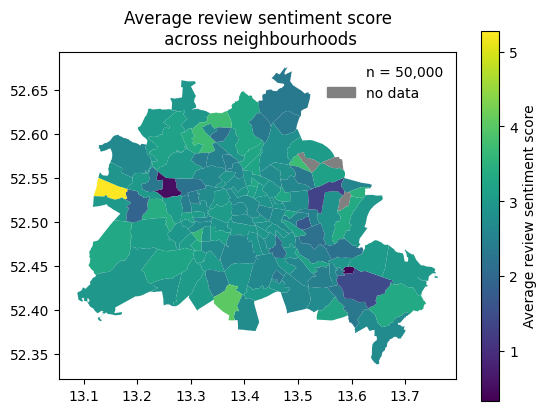

In [46]:
avg_review_sentiment_data = get_neighbourhoods_and_average_sentiment_score()

fig, ax = plt.subplots()
missing_kwds = dict(color='grey')

ax.plot = avg_review_sentiment_data.plot(column = "sentiment", missing_kwds=missing_kwds, ax = ax, legend=True, legend_kwds={'label': "Average review sentiment score"})

number_of_reviews = len(reviews_sentiment_read)
legend_patch = mpatches.Patch(color='white', label='n = ' + f'{number_of_reviews:,}')
no_data_patch = mpatches.Patch(color='grey', label='no data')
ax.legend(handles=[legend_patch, no_data_patch], frameon = False)
ax.set_title("Average review sentiment score\n across neighbourhoods")

plt.show()

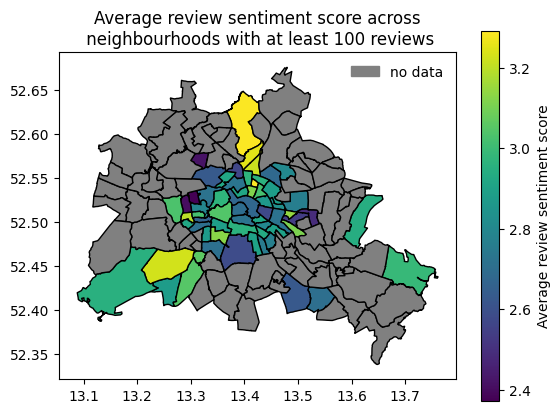

In [57]:
threshold = 100
avg_review_sentiment_data = get_neighbourhoods_and_average_sentiment_score(threshold=threshold)

fig, ax = plt.subplots()

missing_kwds_color = 'grey'
missing_kwds = dict(color=missing_kwds_color)
ax.plot = avg_review_sentiment_data.plot(column = "sentiment", missing_kwds=missing_kwds, edgecolor="black",
 ax = ax, legend=True, legend_kwds={'label': "Average review sentiment score"})

no_data_patch = mpatches.Patch(color=missing_kwds_color, label='no data')
ax.legend(handles=[no_data_patch], frameon = False)

ax.set_title("Average review sentiment score across\n neighbourhoods with at least %s reviews" % threshold)

plt.show()

In [60]:
avg_review_sentiment_data.sort_values(by="sentiment", ascending=False).head(5)

,neighbourhood,neighbourhood_group,geometry,sentiment
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52...",3.291558
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52...",3.285144
27,Pankow Zentrum,Pankow,"MULTIPOLYGON (((13.43113 52.58282, 13.43077 52...",3.251862
57,Zehlendorf Nord,Steglitz - Zehlendorf,"MULTIPOLYGON (((13.22438 52.42947, 13.22406 52...",3.228203
31,Pankow Süd,Pankow,"MULTIPOLYGON (((13.43113 52.58282, 13.43125 52...",3.219557


In [5]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/lebkuchen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lebkuchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lebkuchen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

def preprocess(text):
    # tokenize the text
    tokens = word_tokenize(text)
    
    # remove punctuation and make all characters lowercase
    tokens = [word.lower() for word in tokens if word.isalpha()]
    
    # remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    
    # lemmatize the tokens
    tokens_lemma = [lemmatizer.lemmatize(word) for word in tokens]
    tokens_stem = [stemmer.stem(word) for word in tokens]
    
    return [" ".join(tokens_lemma), " ".join(tokens_stem)]

comments = reviews_sentiment_read.head(5000)[["id", "comments", "sentiment"]]
comments[["comments_lemma", "comments_stem"]] = [preprocess(comment) for comment in comments["comments"]]

In [8]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans

reviews = comments["comments_stem"]

# Create a list of tagged documents
tagged_reviews = [TaggedDocument(review.split(), [i]) for i, review in enumerate(reviews)]

# Train a Doc2Vec model
model = Doc2Vec(tagged_reviews, vector_size=100, window=5, min_count=1, workers=4)

# Extract the vectors for each review
review_vectors = [model.infer_vector(review.split()) for review in reviews]

# Perform k-means clustering
kmeans = KMeans(n_clusters=10, random_state=0).fit(review_vectors)

# Get the cluster assignments for each review
cluster_assignments = kmeans.labels_

/home/lebkuchen/.local/share/virtualenvs/programming-for-data-science-project-3cOvEbYV/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [21]:
from collections import defaultdict
from nltk.probability import FreqDist

# Create an empty defaultdict
clusters_words = defaultdict(list)

# Iterate over each review and cluster assignment
for review, label in zip(reviews, cluster_assignments):
    # Append the review to the list for its corresponding cluster
    clusters_words[label].append(review)

#iterate over clusters and get the most common words
for label, reviews_cluster in clusters_words.items():
    # get the most common words in the reviews of the cluster
    words_distribution = FreqDist([word for review in reviews_cluster for word in review.split()])
    most_common_words = words_distribution.most_common(5)
    print(f"Cluster {label} most common words: {most_common_words}")

Cluster 5 most common words: [('great', 638), ('apart', 535), ('locat', 525), ('stay', 504), ('place', 478)]
Cluster 6 most common words: [('great', 383), ('apart', 379), ('stay', 307), ('locat', 304), ('place', 277)]
Cluster 1 most common words: [('great', 760), ('locat', 631), ('apart', 584), ('place', 561), ('stay', 553)]
Cluster 3 most common words: [('apart', 309), ('stay', 250), ('place', 230), ('berlin', 224), ('us', 214)]
Cluster 7 most common words: [('stay', 521), ('place', 388), ('great', 382), ('berlin', 350), ('apart', 349)]
Cluster 2 most common words: [('apart', 301), ('great', 275), ('stay', 260), ('locat', 215), ('nice', 212)]
Cluster 4 most common words: [('berlin', 103), ('apart', 99), ('stay', 99), ('place', 86), ('great', 65)]
Cluster 8 most common words: [('apart', 165), ('stay', 129), ('room', 107), ('place', 97), ('locat', 92)]
Cluster 9 most common words: [('apart', 99), ('stay', 70), ('also', 50), ('clean', 49), ('us', 45)]
Cluster 0 most common words: [('apar

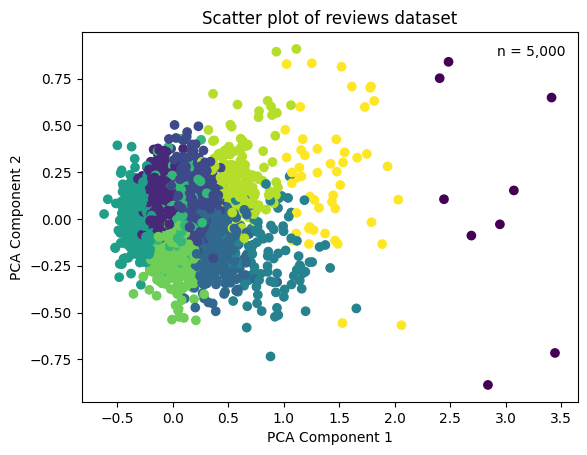

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Use PCA to reduce the dimensionality of the vectors to 2D
pca = PCA(n_components=2)
review_vectors_2d = pca.fit_transform(review_vectors)

# Create a scatter plot
plt.scatter(review_vectors_2d[:, 0], review_vectors_2d[:, 1], c=cluster_assignments, cmap='viridis')

# Add labels to the plot
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Scatter plot of reviews dataset')

legend_patch = mpatches.Patch(color='white', label='n = ' + f'{len(review_vectors_2d):,}')
plt.legend(handles=[legend_patch], frameon = False)

# Display the plot
plt.show()